# Imports

In [1]:
from dotenv import load_dotenv
from datetime import datetime as dt

import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

from pycaret.classification import *

pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(10, 8))
plt.rc("font", size=10)

## Date-Time Parsing

In [51]:
df = pd.read_csv("/workspaces/SE-Europe-Data_Challenge/data/raw/2022_to_2023/gen_DE_B01.csv")

In [52]:
df.drop(['EndTime', 'UnitName', 'AreaID', 'PsrType'], axis=1, inplace=True)
df.rename(columns={'StartTime': 'start_time', 'quantity': 'energy_generated'}, inplace=True)
df.sort_values(['start_time'], inplace=True)

In [45]:

d1 = dt.strptime("2021-12-31T23:45+00:00Z","%Y-%m-%dT%H:%M%zZ")

In [46]:
d1

datetime.datetime(2021, 12, 31, 23, 45, tzinfo=datetime.timezone.utc)

In [47]:
new_format = "%Y-%m-%d %H:%M:%S"

In [48]:
d1.strftime(new_format)

'2021-12-31 23:45:00'

In [49]:
type(d1)

datetime.datetime

## EDA Training Data

In [2]:
data = pd.read_csv("/workspaces/SE-Europe-Data_Challenge/data/processed.csv")

In [3]:
data.columns

Index(['start_time', 'green_energy_DE', 'DE_Load', 'green_energy_HU',
       'HU_Load', 'green_energy_IT', 'IT_Load', 'green_energy_PO', 'PO_Load',
       'green_energy_SP', 'SP_Load', 'green_energy_UK', 'UK_Load',
       'green_energy_DK', 'DK_Load', 'green_energy_SE', 'SE_Load',
       'green_energy_NE', 'NE_Load'],
      dtype='object')

In [4]:
data.shape

(8761, 19)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8761 entries, 0 to 8760
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start_time       8761 non-null   object 
 1   green_energy_DE  8761 non-null   int64  
 2   DE_Load          8761 non-null   int64  
 3   green_energy_HU  8761 non-null   int64  
 4   HU_Load          8761 non-null   int64  
 5   green_energy_IT  8761 non-null   float64
 6   IT_Load          8761 non-null   float64
 7   green_energy_PO  8761 non-null   float64
 8   PO_Load          8761 non-null   float64
 9   green_energy_SP  8761 non-null   int64  
 10  SP_Load          8761 non-null   int64  
 11  green_energy_UK  8761 non-null   float64
 12  UK_Load          8761 non-null   float64
 13  green_energy_DK  8761 non-null   float64
 14  DK_Load          8761 non-null   float64
 15  green_energy_SE  8761 non-null   float64
 16  SE_Load          8761 non-null   float64
 17  green_energy_N

In [6]:
for column in data.columns:
    if column != 'start_time':  # Skipping the 'start_time' column
        data[column] = data[column].astype(int)

In [7]:
data.dtypes

start_time         object
green_energy_DE     int64
DE_Load             int64
green_energy_HU     int64
HU_Load             int64
green_energy_IT     int64
IT_Load             int64
green_energy_PO     int64
PO_Load             int64
green_energy_SP     int64
SP_Load             int64
green_energy_UK     int64
UK_Load             int64
green_energy_DK     int64
DK_Load             int64
green_energy_SE     int64
SE_Load             int64
green_energy_NE     int64
NE_Load             int64
dtype: object

In [8]:
data.isnull().sum()

start_time         0
green_energy_DE    0
DE_Load            0
green_energy_HU    0
HU_Load            0
green_energy_IT    0
IT_Load            0
green_energy_PO    0
PO_Load            0
green_energy_SP    0
SP_Load            0
green_energy_UK    0
UK_Load            0
green_energy_DK    0
DK_Load            0
green_energy_SE    0
SE_Load            0
green_energy_NE    0
NE_Load            0
dtype: int64

In [26]:
processed_df = data.copy(deep=True)

In [27]:
# Calculating the surplus for each country and creating the label column

# Country IDs as provided
country_ids = {
    'DE': 0, 'HU': 1, 'IT': 2, 'PO': 3, 'SP': 4,
    'UK': 5, 'DK': 6, 'SE': 7, 'NE': 8
}


In [28]:
# Calculate surplus for each country
for country_code in country_ids.keys():
    green_energy_col = f'green_energy_{country_code}'
    load_col = f'{country_code}_Load'
    surplus_col = f'{country_code}_surplus'
    processed_df[surplus_col] = processed_df[green_energy_col] - processed_df[load_col]

In [29]:
# Determine the country with the highest surplus for each hour
surplus_cols = [f'{code}_surplus' for code in country_ids.keys()]
processed_df['highest_surplus_country'] = processed_df[surplus_cols].idxmax(axis=1)
processed_df['highest_surplus_country'] = processed_df['highest_surplus_country'].apply(lambda x: country_ids[x.split('_')[0]])

In [30]:
processed_df.shape

(8761, 29)

In [31]:
processed_df.isnull().sum()

start_time                 0
green_energy_DE            0
DE_Load                    0
green_energy_HU            0
HU_Load                    0
green_energy_IT            0
IT_Load                    0
green_energy_PO            0
PO_Load                    0
green_energy_SP            0
SP_Load                    0
green_energy_UK            0
UK_Load                    0
green_energy_DK            0
DK_Load                    0
green_energy_SE            0
SE_Load                    0
green_energy_NE            0
NE_Load                    0
DE_surplus                 0
HU_surplus                 0
IT_surplus                 0
PO_surplus                 0
SP_surplus                 0
UK_surplus                 0
DK_surplus                 0
SE_surplus                 0
NE_surplus                 0
highest_surplus_country    0
dtype: int64

In [32]:
# Correcting the filtering process for the year 2022

processed_df['start_time'] = pd.to_datetime(processed_df['start_time'])

processed_df_2022 = processed_df[processed_df['start_time'].dt.year == 2022]

# Displaying the first few rows of the filtered DataFrame
processed_df_2022.head()

,start_time,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_PO,PO_Load,green_energy_SP,...,DE_surplus,HU_surplus,IT_surplus,PO_surplus,SP_surplus,UK_surplus,DK_surplus,SE_surplus,NE_surplus,highest_surplus_country
1,2022-01-01 00:00:00,157373,165125,1376,16457,5745,19756,4491,13935,10827,...,-7752,-15081,-14011,-9444,-8703,-1244,387,-4224,-27938,6
2,2022-01-01 01:00:00,151747,160415,1526,15426,6228,18685,4436,13579,11140,...,-8668,-13900,-12457,-9143,-7243,-1131,183,-4234,-28334,6
3,2022-01-01 02:00:00,147938,158035,1560,14781,6407,18124,4568,13397,11361,...,-10097,-13221,-11717,-8829,-6319,-1091,-37,-4641,-27599,6
4,2022-01-01 03:00:00,141816,157016,1287,14630,5760,18400,4559,13364,11247,...,-15200,-13343,-12640,-8805,-6149,-969,-192,-4617,-26921,6
5,2022-01-01 04:00:00,131970,154552,1309,14688,5501,19223,4374,13449,10868,...,-22582,-13379,-13722,-9075,-6676,-896,-406,-4885,-27053,6


In [33]:
processed_df_2022.shape

(8760, 29)

In [24]:
exp = ClassificationExperiment()

In [25]:
type(exp)

pycaret.classification.oop.ClassificationExperiment

In [40]:
exp_name = setup(processed_df_2022, target = 'highest_surplus_country', train_size=0.8, session_id = 123)

,Description,Value
0,Session id,123
1,Target,highest_surplus_country
2,Target type,Multiclass
3,Target mapping,"0: 0, 4: 1, 5: 2, 6: 3, 7: 4"
4,Original data shape,"(8760, 29)"
5,Transformed data shape,"(8760, 31)"
6,Transformed train set shape,"(7008, 31)"
7,Transformed test set shape,"(1752, 31)"
8,Numeric features,27
9,Date features,1


In [41]:
best_model = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:39:03
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9900,0.9994,0.9900,0.9904,0.9900,0.9809,0.9810,1.4360
lightgbm,Light Gradient Boosting Machine,0.9843,0.9995,0.9843,0.9844,0.9842,0.9699,0.9700,7.4360
gbc,Gradient Boosting Classifier,0.9802,0.9986,0.9802,0.9803,0.9799,0.9620,0.9621,17.0490
dt,Decision Tree Classifier,0.9709,0.9735,0.9709,0.9714,0.9709,0.9443,0.9444,0.1320
rf,Random Forest Classifier,0.9673,0.9977,0.9673,0.9672,0.9666,0.9370,0.9372,1.4250
et,Extra Trees Classifier,0.9439,0.9940,0.9439,0.9437,0.9422,0.8914,0.8919,0.4730
lda,Linear Discriminant Analysis,0.9055,0.9823,0.9055,0.8985,0.8998,0.8157,0.8165,0.0720
svm,SVM - Linear Kernel,0.8915,0.0000,0.8915,0.9051,0.8788,0.7846,0.7961,0.1720
ridge,Ridge Classifier,0.8824,0.0000,0.8824,0.8171,0.8484,0.7583,0.7654,0.0660
knn,K Neighbors Classifier,0.7536,0.8413,0.7536,0.7424,0.7421,0.5046,0.5084,0.0930


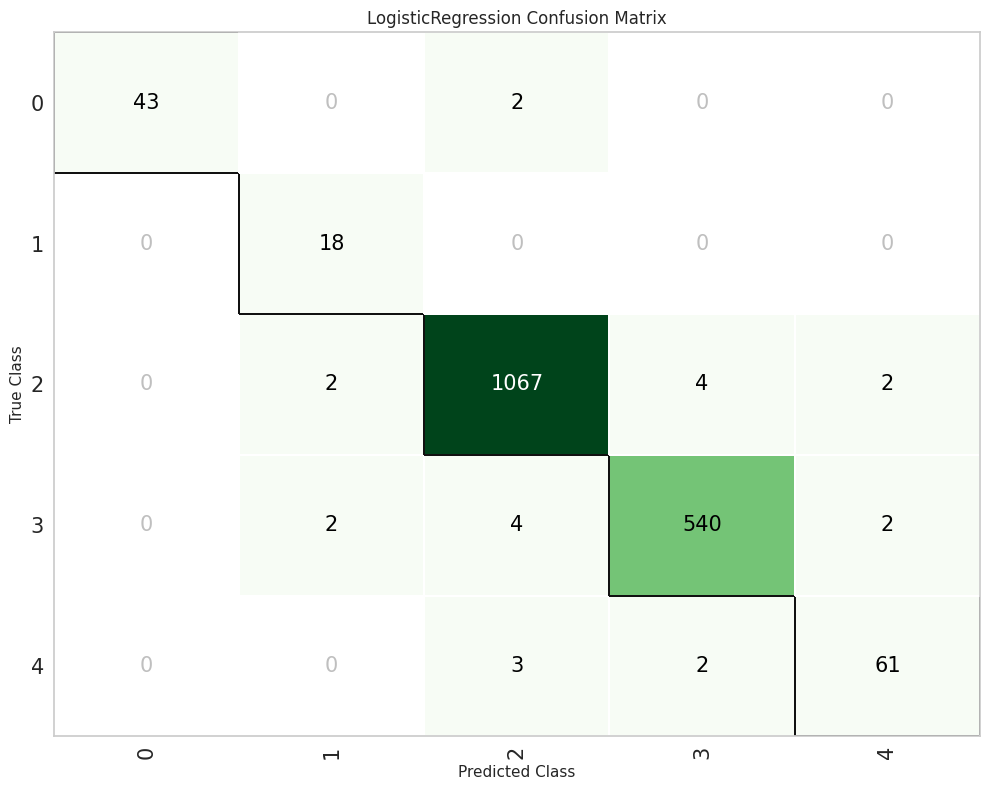

In [42]:
# plot confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

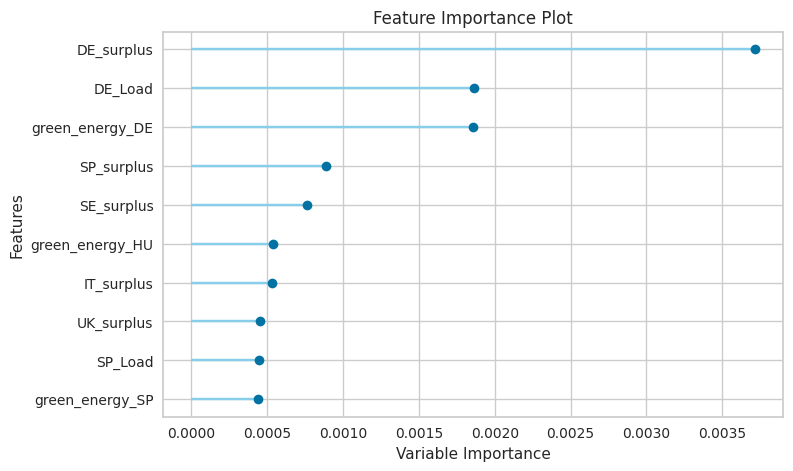

In [43]:
# plot feature importance
plot_model(best_model, plot = 'feature')

In [44]:
# predict on test set
holdout_pred = predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9869,0.9992,0.9869,0.9872,0.9869,0.9749,0.9749


In [45]:
# show predictions df
holdout_pred.head()

,start_time,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_PO,PO_Load,green_energy_SP,...,IT_surplus,PO_surplus,SP_surplus,UK_surplus,DK_surplus,SE_surplus,NE_surplus,highest_surplus_country,prediction_label,prediction_score
5119,2022-08-02 06:00:00,110296,236121,4670,18414,14576,43856,3959,20953,36584,...,-29280,-16994,-83092,0,-1404,-1949,-33046,5,5,1.0
6324,2022-09-21 11:00:00,155155,238510,5756,18237,14958,36610,5298,21127,62708,...,-21652,-15829,-60124,0,-2320,-3707,-33956,5,5,1.0
7074,2022-10-22 17:00:00,92866,205840,811,20453,8429,29919,2180,19648,63148,...,-21490,-17468,-37244,0,-2234,-1693,-45473,5,5,1.0
7360,2022-11-03 15:00:00,150865,259649,1303,22638,9893,39444,4392,23375,63632,...,-29551,-18983,-45620,27,-1490,-1585,-44015,5,5,1.0
7793,2022-11-21 16:00:00,95830,267750,813,24612,12041,39437,1514,25252,96680,...,-27396,-23738,-25772,1201,-3166,-6892,-52817,5,5,1.0


In [18]:
# Splitting the dataset into training and testing sets

# Since this is time-series data, we'll perform a chronological split (not random)
# We'll use the last 20% of the data as the test set

split_index = int(len(processed_df) * 0.8)
train_df = processed_df.iloc[:split_index]
test_df = processed_df.iloc[split_index:]

# Verifying the split
train_test_split_info = {
    "Total Data Points": len(processed_df),
    "Training Data Points": len(train_df),
    "Testing Data Points": len(test_df),
    "Split Index": split_index
}

train_test_split_info

{'Total Data Points': 8761,
 'Training Data Points': 7008,
 'Testing Data Points': 1753,
 'Split Index': 7008}

In [19]:
train_df

,start_time,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_PO,PO_Load,green_energy_SP,...,DE_Surplus,HU_Surplus,IT_Surplus,PO_Surplus,SP_Surplus,UK_Surplus,DK_Surplus,SE_Surplus,NE_Surplus,Highest_Surplus_Country
0,2021-12-31 23:00:00,39401,42196,285,4254,5801,21121,4641,14438,11244,...,-2795,-3969,-15320,-9797,-9583,-677,338,-4271,-6772,6
1,2022-01-01 00:00:00,157373,165125,1376,16457,5745,19756,4491,13935,10827,...,-7752,-15081,-14011,-9444,-8703,-1244,387,-4224,-27938,6
2,2022-01-01 01:00:00,151747,160415,1526,15426,6228,18685,4436,13579,11140,...,-8668,-13900,-12457,-9143,-7243,-1131,183,-4234,-28334,6
3,2022-01-01 02:00:00,147938,158035,1560,14781,6407,18124,4568,13397,11361,...,-10097,-13221,-11717,-8829,-6319,-1091,-37,-4641,-27599,6
4,2022-01-01 03:00:00,141816,157016,1287,14630,5760,18400,4559,13364,11247,...,-15200,-13343,-12640,-8805,-6149,-969,-192,-4617,-26921,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,2022-10-19 18:00:00,90655,230415,1257,21403,5998,33929,2165,20967,61588,...,-139760,-20146,-27931,-18802,-62356,0,-2893,-2363,-37631,5
7004,2022-10-19 19:00:00,97665,219712,1334,19881,5534,30737,1858,19492,60820,...,-122047,-18547,-25203,-17634,-55376,0,-2549,-2053,-33839,5
7005,2022-10-19 20:00:00,106556,205298,1330,18996,5931,28335,1537,18162,51504,...,-98742,-17666,-22404,-16625,-53568,0,-2217,-2224,-30616,5
7006,2022-10-19 21:00:00,119703,192025,1153,18231,5776,26202,1324,17065,43920,...,-72322,-17078,-20426,-15741,-53348,0,-1848,-2201,-28697,5


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Preparing the feature columns for model training
feature_columns = surplus_cols  # Using surplus columns as features
X_train = train_df[feature_columns]
y_train = train_df['Highest_Surplus_Country']

X_test = test_df[feature_columns]
y_test = test_df['Highest_Surplus_Country']

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Calculate the F1 score
f1_score_value = f1_score(y_test, predictions, average='macro')
f1_score_value

0.6636990820741854

In [35]:
import json

# Preparing the predictions in the required format
predictions_dict = {"predictions": predictions.tolist()}

# Path to save the predictions.json file
predictions_json_path = 'data/predictions.json'

# Writing the predictions to a JSON file
with open(predictions_json_path, 'w') as file:
    json.dump(predictions_dict, file)

predictions_json_path

'data/predictions.json'

In [36]:
# Reading the content of the predictions.json file and checking its length

with open(predictions_json_path, 'r') as file:
    predictions_json = json.load(file)

# Getting the length of the predictions list
predictions_length = len(predictions_json["predictions"])
predictions_length

1753

In [40]:
def basic_exploration(file_path):
    df = pd.read_csv(file_path)
    print(f"""\nThe column names in the data are: \n{df.columns}\n{'x' * 60}
          The datatypes of the columns are: \n{df.dtypes}
          {'x' * 60}
          The minimum value of StartTime: {df['StartTime'].min()}
          The maximum value of StartTime: {df['StartTime'].max()}
          The minimum value of EndTime: {df['EndTime'].min()}
          The maximum value of EndTime: {df['EndTime'].max()}
          The minimum value of energy generated:  {df['quantity'].min()}
          The maximum value of energy generated: {df['quantity'].max()}
          """)

In [39]:
basic_exploration("/workspaces/SE-Europe-Data_Challenge/data/processed/2022_to_2023/gen_UK_B19_modified.csv")


The column names in the data are: 
Index(['StartTime', 'EndTime', 'AreaID', 'UnitName', 'PsrType', 'quantity',
       'time_interval'],
      dtype='object')
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
          The datatypes of the columns are: 
StartTime        object
EndTime          object
AreaID           object
UnitName         object
PsrType          object
quantity          int64
time_interval    object
dtype: object
          xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
          The minimum value of StartTime: 2022-01-26 23:30:00+00:00
          The maximum value of StartTime: 2022-12-31 23:00:00+00:00
          The minimum value of EndTime: 2022-01-27 00:00:00+00:00
          The maximum value of EndTime: 2022-12-31 23:30:00+00:00
          The minimum value of energy generated:  0
          The maximum value of energy generated: 1052
          
          
          
